In [1]:
import cse_pandas as cse_pd
import utils

## Introduction

This notebook demonstrates the capabilities of **cse_pandas** class. 

The class relies on the **cse_s3_client** which is an implementation of client side encryption using boto3. It uses modified code from the [aiboto3 library](https://github.com/terrycain/aioboto3). The aiboto3 library supports CSE but it is tightly coupled with asynchronous nature of the library, which is not easy or practical to use from environments such as Jypyter notebooks. The re-implementation simplifies the code and makes it easier to use alongside boto3. 

In addition,cse_pandas,  provides methods for reading panda dataframes form  both plaintext and client-side-encrypted (CSE) s3 objects abstracting the s3 semantics. 

It also allows writting dataframes to S3 as  either plain text or CSE. It supports delimited(csv,tsb,etc) and parquet files and it can be used to convert from one format to another. 

The class emulates the pandas **read_csv**/**write_csv** and **read_parquet**/**write_parquet** methods with the same signature but *with the addition of the bucket and object key parameters as well as an optional cms_id** which when specified will store the dataframe with cse-kms;when reading the libraries will automatically use the cmk id found in the object's metadata. However, this can be overriden by supplying the cmk_id parameter which will be used instead. This can be useful in manual key rotation scenarios.

The class provides helper methods to query the encryption status and return metadata of an s3 object as dataframe  and a built-in helper CSEPerformanceCounters object which allows to query and report performance data as dataframes.


This notebook demonstrates the above functionality with the  the direct marketing dataset used in the AWS Sagemaker Immersion Day downloaded from the sample data s3 bucket.

[Moro et al., 2014] S. Moro, P. Cortez and P. Rita. A Data-Driven Approach to Predict the Success of Bank Telemarketing. Decision Support Systems, Elsevier, 62:22-31, June 201

In [2]:
bucket = "sagemaker-studio-t9sc0jup0m8"
filename = "bank-additional/bank-additional-full.csv"

df=cse_pd.read_csv_df(bucket,filename)
df.head()

2022-02-14 20:30:22,533: INFO: Found credentials in shared credentials file: ~/.aws/credentials
2022-02-14 20:30:22,642: INFO: Downloading object and its metadata from S3
2022-02-14 20:30:24,111: INFO: bank-additional/bank-additional-full.csv was read in 0.030472420999999805 seconds


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [3]:
df.shape

(41188, 21)

In [4]:
metadata = cse_pd.file_metadata(bucket,filename)
print(f"Is file encrypted? {cse_pd.is_encrypted(metadata)}")
print('S3 Metadata')
cse_pd.metadata_df(metadata)

2022-02-14 20:30:30,532: INFO: Retrieving object metadata from S3 without downloading the object itself
2022-02-14 20:30:30,971: INFO: Metadata for bank-additional/bank-additional-full.csv was read in 0.01649207499999994 seconds


Is file encrypted? False
S3 Metadata


,Key,Value


Create an unencrypted copy by not specifying a CMK

In [5]:
copy_filename=utils.generated_object_key(filename,"copy","csv")
cse_cmk_us = "arn:aws:kms:us-east-1:299691842772:alias/cse-us"
copy_object_key=cse_pd.write_csv_df(df, bucket,copy_filename, index=False)
print(copy_object_key)

2022-02-14 20:30:39,004: INFO: Writing object and its metadata to S3 (no CSE)
2022-02-14 20:30:41,424: INFO: bank-additional/bank-additional-full-copy.csv was writen in 0.08059179199999988 seconds


bank-additional/bank-additional-full-copy.csv


Ensure we can read the unencrypted copy and its identical to the original

In [6]:
copy_df=cse_pd.read_csv_df(bucket,copy_object_key)
print("Are the two datasets identical?",df.equals(copy_df))
copy_df.head()

2022-02-14 20:30:43,809: INFO: Downloading object and its metadata from S3
2022-02-14 20:30:45,073: INFO: bank-additional/bank-additional-full-copy.csv was read in 0.023180095999999928 seconds


Are the two datasets identical? True


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


Create an encrypted copy with CSE-KMS using a KMS CMK i.e cmk_id=cse_cmk_us

In [7]:
cse_cmk_us = "arn:aws:kms:us-east-1:299691842772:alias/cse-us"
encrypted_filename=utils.generated_object_key(filename,"encrypted","csv")
object_key=cse_pd.write_csv_df(df, bucket,encrypted_filename, cmk_id=cse_cmk_us, index=False)
print(object_key)

2022-02-14 20:30:50,856: INFO: Writing object and its metadata to S3 (CSE using CMK arn:aws:kms:us-east-1:299691842772:alias/cse-us)
2022-02-14 20:30:53,735: INFO: bank-additional/bank-additional-full-encrypted.csv was writen in 0.16897869200000004 seconds


bank-additional/bank-additional-full-encrypted.csv


Confirm encryption from metadata

In [8]:
metadata = cse_pd.file_metadata(bucket,object_key)
print(f"Is file encrypted? {cse_pd.is_encrypted(metadata)}")
print('S3 Metadata')
cse_pd.metadata_df(metadata)

2022-02-14 20:30:54,169: INFO: Retrieving object metadata from S3 without downloading the object itself
2022-02-14 20:30:54,622: INFO: Metadata for bank-additional/bank-additional-full-encrypted.csv was read in 0.024394614000000203 seconds


Is file encrypted? True
S3 Metadata


,Key,Value
0,x-amz-tag-len,128
1,x-amz-unencrypted-content-length,4974759
2,x-amz-wrap-alg,kms
3,x-amz-matdesc,"{""kms_cmk_id"": ""arn:aws:kms:us-east-1:29969184..."
4,x-amz-key-v2,AQIDAHgTkqfXAKlb7mEny/rGzSpLgyK/Jm4NSBJpdtgwnQ...
5,x-amz-cek-alg,AES/GCM/NoPadding
6,x-amz-iv,2wX+gpiQ3YyQQv91


Create a second data frame from the encrypted object

In [9]:
encrypted_df = cse_pd.read_csv_df(bucket,object_key)
encrypted_df.head()

2022-02-14 20:30:58,807: INFO: Downloading object and its metadata from S3
2022-02-14 20:31:00,484: INFO: bank-additional/bank-additional-full-encrypted.csv was read in 0.10652307799999994 seconds


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [11]:
#Are the two data frames the same?
df.equals(encrypted_df)

True

In [13]:
#Convert to parquet and save unencrypted

parquet_filename = utils.generated_object_key(filename,"","parquet")
parquet_object_key=cse_pd.write_parquet_df(df, bucket, parquet_filename, index=False)
print(parquet_object_key)

2022-02-14 20:33:30,609: INFO: Writing object and its metadata to S3 (no CSE)
2022-02-14 20:33:31,620: INFO: bank-additional/bank-additional-full.parquet was writen in 0.0323749409999996 seconds


bank-additional/bank-additional-full.parquet


In [14]:
metadata = cse_pd.file_metadata(bucket,parquet_object_key)
print(f"Is file encrypted? {cse_pd.is_encrypted(metadata)}")
print('S3 Metadata')
cse_pd.metadata_df(metadata)

2022-02-14 20:34:02,843: INFO: Retrieving object metadata from S3 without downloading the object itself
2022-02-14 20:34:03,293: INFO: Metadata for bank-additional/bank-additional-full.parquet was read in 0.01923192899999915 seconds


Is file encrypted? False
S3 Metadata


,Key,Value


In [15]:
parquet_df = cse_pd.read_parquet_df(bucket,parquet_object_key)
parquet_df.head()

2022-02-14 20:34:07,707: INFO: Downloading object and its metadata from S3
2022-02-14 20:34:08,447: INFO: bank-additional/bank-additional-full.parquet was read in 0.022242297000000022 seconds


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [16]:
#Are the two data frames the same?
df.equals(parquet_df)

True

In [18]:
# save parquet encrypted
encrypted_parquet_filename = utils.generated_object_key(filename,"encrypted","parquet")

encrypted_parquet_object_key=cse_pd.write_parquet_df(df, bucket,encrypted_parquet_filename, cmk_id= cse_cmk_us , index=False)
print(encrypted_parquet_object_key)

2022-02-14 20:34:45,064: INFO: Writing object and its metadata to S3 (CSE using CMK arn:aws:kms:us-east-1:299691842772:alias/cse-us)
2022-02-14 20:34:46,944: INFO: bank-additional/bank-additional-full-encrypted.parquet was writen in 0.07244991100000053 seconds


bank-additional/bank-additional-full-encrypted.parquet


In [19]:
metadata = cse_pd.file_metadata(bucket,encrypted_parquet_object_key)
print(f"Is file encrypted? {cse_pd.is_encrypted(metadata)}")
print('S3 Metadata')
cse_pd.metadata_df(metadata)

2022-02-14 20:34:50,512: INFO: Retrieving object metadata from S3 without downloading the object itself
2022-02-14 20:34:51,309: INFO: Metadata for bank-additional/bank-additional-full-encrypted.parquet was read in 0.015249096999999878 seconds


Is file encrypted? True
S3 Metadata


,Key,Value
0,x-amz-tag-len,128
1,x-amz-unencrypted-content-length,236449
2,x-amz-wrap-alg,kms
3,x-amz-matdesc,"{""kms_cmk_id"": ""arn:aws:kms:us-east-1:29969184..."
4,x-amz-key-v2,AQIDAHgTkqfXAKlb7mEny/rGzSpLgyK/Jm4NSBJpdtgwnQ...
5,x-amz-cek-alg,AES/GCM/NoPadding
6,x-amz-iv,LVbLWAaVHSlybsCu


In [20]:
# read the encrypted parquet file
encrypted_parquet_df = cse_pd.read_parquet_df(bucket, encrypted_parquet_object_key)
encrypted_parquet_df.head()

2022-02-14 20:34:55,447: INFO: Downloading object and its metadata from S3
2022-02-14 20:34:56,817: INFO: bank-additional/bank-additional-full-encrypted.parquet was read in 0.056919322000000605 seconds


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [21]:
counters_df = cse_pd.get_performance_counters()
counters_df

,timestamp,bucket,object_key,file_type,operation,cse,duration
0,Mon Feb 14 20:30:23 2022,sagemaker-studio-t9sc0jup0m8,bank-additional/bank-additional-full.csv,csv,read,NO CSE,0.030472
1,Mon Feb 14 20:30:30 2022,sagemaker-studio-t9sc0jup0m8,bank-additional/bank-additional-full.csv,csv,head,NO CSE,0.016492
2,Mon Feb 14 20:30:41 2022,sagemaker-studio-t9sc0jup0m8,bank-additional/bank-additional-full-copy.csv,csv,write,NO CSE,0.080592
3,Mon Feb 14 20:30:44 2022,sagemaker-studio-t9sc0jup0m8,bank-additional/bank-additional-full-copy.csv,csv,read,NO CSE,0.023180
4,Mon Feb 14 20:30:53 2022,sagemaker-studio-t9sc0jup0m8,bank-additional/bank-additional-full-encrypted...,csv,write,CSE,0.168979
5,Mon Feb 14 20:30:54 2022,sagemaker-studio-t9sc0jup0m8,bank-additional/bank-additional-full-encrypted...,csv,head,NO CSE,0.024395
6,Mon Feb 14 20:31:00 2022,sagemaker-studio-t9sc0jup0m8,bank-additional/bank-additional-full-encrypted...,csv,read,CSE,0.106523
7,Mon Feb 14 20:33:31 2022,sagemaker-studio-t9sc0jup0m8,bank-additional/bank-additional-full.parquet,parquet,write,NO CSE,0.032375
8,Mon Feb 14 20:34:03 2022,sagemaker-studio-t9sc0jup0m8,bank-additional/bank-additional-full.parquet,parquet,head,NO CSE,0.019232
9,Mon Feb 14 20:34:08 2022,sagemaker-studio-t9sc0jup0m8,bank-additional/bank-additional-full.parquet,parquet,read,NO CSE,0.022242


In [22]:
readwrite_df=counters_df[counters_df['operation']!='head']
readwrite_df = readwrite_df.iloc[1:, :]

In [23]:
readwrite_df

,timestamp,bucket,object_key,file_type,operation,cse,duration
2,Mon Feb 14 20:30:41 2022,sagemaker-studio-t9sc0jup0m8,bank-additional/bank-additional-full-copy.csv,csv,write,NO CSE,0.080592
3,Mon Feb 14 20:30:44 2022,sagemaker-studio-t9sc0jup0m8,bank-additional/bank-additional-full-copy.csv,csv,read,NO CSE,0.023180
4,Mon Feb 14 20:30:53 2022,sagemaker-studio-t9sc0jup0m8,bank-additional/bank-additional-full-encrypted...,csv,write,CSE,0.168979
6,Mon Feb 14 20:31:00 2022,sagemaker-studio-t9sc0jup0m8,bank-additional/bank-additional-full-encrypted...,csv,read,CSE,0.106523
7,Mon Feb 14 20:33:31 2022,sagemaker-studio-t9sc0jup0m8,bank-additional/bank-additional-full.parquet,parquet,write,NO CSE,0.032375
9,Mon Feb 14 20:34:08 2022,sagemaker-studio-t9sc0jup0m8,bank-additional/bank-additional-full.parquet,parquet,read,NO CSE,0.022242
10,Mon Feb 14 20:34:46 2022,sagemaker-studio-t9sc0jup0m8,bank-additional/bank-additional-full-encrypted...,parquet,write,CSE,0.072450
12,Mon Feb 14 20:34:56 2022,sagemaker-studio-t9sc0jup0m8,bank-additional/bank-additional-full-encrypted...,parquet,read,CSE,0.056919


In [24]:
readwrite_df= readwrite_df[readwrite_df['file_type']=='csv']
readwrite_df

,timestamp,bucket,object_key,file_type,operation,cse,duration
2,Mon Feb 14 20:30:41 2022,sagemaker-studio-t9sc0jup0m8,bank-additional/bank-additional-full-copy.csv,csv,write,NO CSE,0.080592
3,Mon Feb 14 20:30:44 2022,sagemaker-studio-t9sc0jup0m8,bank-additional/bank-additional-full-copy.csv,csv,read,NO CSE,0.023180
4,Mon Feb 14 20:30:53 2022,sagemaker-studio-t9sc0jup0m8,bank-additional/bank-additional-full-encrypted...,csv,write,CSE,0.168979
6,Mon Feb 14 20:31:00 2022,sagemaker-studio-t9sc0jup0m8,bank-additional/bank-additional-full-encrypted...,csv,read,CSE,0.106523


In [25]:
import utils
summary_df = utils.counters_summary_df(readwrite_df, 'operation', 'cse', 'duration')
summary_df

,CSE,NO CSE
operation,,
write,0.168979,0.080592
read,0.106523,0.023180


<AxesSubplot:title={'center':'read/write times for CSV objects'}, xlabel='operation'>

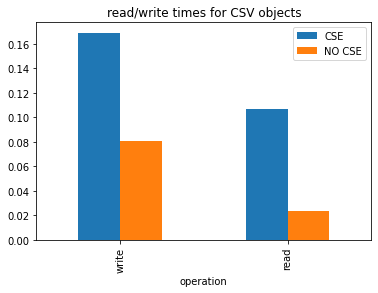

In [26]:
summary_df.plot(kind="bar",title='read/write times for CSV objects')

In [27]:
readwrite_df= counters_df[counters_df['operation']!='head']
readwrite_df= readwrite_df[readwrite_df['file_type']=='parquet']
readwrite_df

,timestamp,bucket,object_key,file_type,operation,cse,duration
7,Mon Feb 14 20:33:31 2022,sagemaker-studio-t9sc0jup0m8,bank-additional/bank-additional-full.parquet,parquet,write,NO CSE,0.032375
9,Mon Feb 14 20:34:08 2022,sagemaker-studio-t9sc0jup0m8,bank-additional/bank-additional-full.parquet,parquet,read,NO CSE,0.022242
10,Mon Feb 14 20:34:46 2022,sagemaker-studio-t9sc0jup0m8,bank-additional/bank-additional-full-encrypted...,parquet,write,CSE,0.072450
12,Mon Feb 14 20:34:56 2022,sagemaker-studio-t9sc0jup0m8,bank-additional/bank-additional-full-encrypted...,parquet,read,CSE,0.056919


In [28]:
summary_df = utils.counters_summary_df(readwrite_df, 'operation', 'cse', 'duration')
summary_df

,CSE,NO CSE
operation,,
write,0.072450,0.032375
read,0.056919,0.022242


<AxesSubplot:title={'center':'read/write times for parquet objects'}, xlabel='operation'>

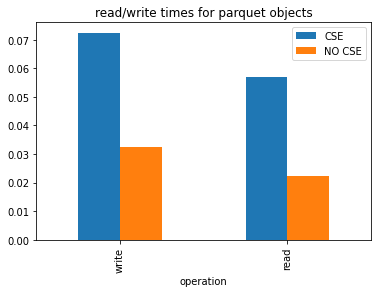

In [29]:
summary_df.plot(kind="bar",title='read/write times for parquet objects')